<a href="https://colab.research.google.com/github/kameshDiviyanjana/DL-9/blob/main/CGAN_MNIST_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization:** The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape:** The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [2]:
# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Build Generator

### This generator is part of a CGAN that generates images according to the given label.

### It combines random noise with a label to create a specific image class (e.g., generating a "2" when the label is 2).

In [3]:
# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

generator = build_generator()
build_generator().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 100)         │          1,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100)            │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 100)            │              0 │ input_layer_3[0][0],   │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 28, 28, 1)      │      1,493,520 │ multiply_1[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,494,520 (5.70 MB)

 Trainable params: 1,490,936 (5.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

# Build Discriminator Model

### This model is a discriminator in a CGAN. It takes both an image and a label as input and determines whether the image is real or fake, based on the given label.

### By combining the image and label inputs, the discriminator can ensure that the image corresponds to the specified label before deciding if it's real or fake.

In [5]:
# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding the label input to match the shape of the image input
    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate the image and label embeddings along the channel dimension
    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))  # Update the input shape here
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

# Build the discriminator and print the summary
discriminator = build_discriminator()
discriminator.summary()


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 784)         │          7,840 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 784)            │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 28, 28, 1)      │              0 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 28, 28, 2)      │              0 │ input_layer_9[0][0],   │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 1)              │        934,913 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 942,753 (3.60 MB)

 Trainable params: 942,753 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

# Build and Compile the Models

### The **discriminator** is compiled with the Adam optimizer and binary cross-entropy loss since it needs to classify whether the input is real or fake (binary classification). The accuracy metric is also tracked.

### The **GAN** model is created by combining the generator and discriminator. It takes random noise and a label as input, generates an image, and then passes that image (along with the label) to the discriminator to check if it's real or fake.

### The GAN is also compiled with binary cross-entropy loss since it still involves distinguishing between real and fake images.

In [6]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the Function

### Two arrays, real and fake, are created to represent the target labels: 1 for real images and 0 for fake images.

### The loop runs for a specified number of epochs, where a random batch of real images and their corresponding labels is selected from the dataset for each iteration.

### **Random noise** is generated and fed into the generator (along with the labels) to create fake images.

### The **discriminator** is trained on both the real images (with label 1) and the generated (fake) images (with label 0). The final loss for the discriminator is the average of the two losses.

### The generator is trained through the GAN by trying to fool the discriminator into thinking the generated images are real. The target labels for this are 1 (real) because the generator is rewarded when it can make the discriminator believe its images are real.

In [7]:
# # Training function
# def train(epochs, batch_size=128, save_interval=200):
#     real = np.ones((batch_size, 1))
#     fake = np.zeros((batch_size, 1))

#     for epoch in range(epochs):
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         real_images, labels = X_train[idx], Y_train[idx]

#         noise = np.random.normal(0, 1, (batch_size, 100))
#         fake_images = generator.predict([noise, labels])

#         d_loss_real = discriminator.train_on_batch([real_images, labels], real)
#         d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         g_loss = gan.train_on_batch([noise, labels], real)

#         if epoch % save_interval == 0:
#             print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
#             save_images(epoch)

def train(epochs, batch_size=128, save_interval=200, specific_digit=None):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        # Filter for the specific digit if provided
        if specific_digit is not None:
            digit_indices = np.where(Y_train == specific_digit)[0]
            idx = np.random.choice(digit_indices, batch_size)
            real_images, labels = X_train[idx], Y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch([noise, labels], real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch, specific_digit=specific_digit)




# Saving Generated Images

### This function generates and saves images at each specified interval. It generates 10 images (for digits 0-9) by feeding random noise and the corresponding labels into the generator.

### The images are rescaled from the range [-1, 1] to [0, 1] for display. A 2x5 grid of images is created and displayed.

In [8]:
# # Function to save generated images
# def save_images(epoch):
#     r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
#     noise = np.random.normal(0, 1, (r * c, 100))
#     labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Generate digits 0-9
#     gen_images = generator.predict([noise, labels])
#     gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
#             axs[i, j].set_title(f"Digit: {labels[cnt]}")
#             axs[i, j].axis('off')
#             cnt += 1
#     plt.show()

# # Train the CGAN
# train(epochs=1000, batch_size=64, save_interval=1000)
def save_images(epoch, specific_digit=None):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))

    if specific_digit is not None:
        labels = np.full((r * c,), specific_digit)  # Generate only the specific digit
    else:
        labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Generate digits 0-9

    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()


# Question 01

## **Modify the CGAN to generate images for specific digits (e.g., generate only '7' or '9').**

---

# Question 02

## **Add label smoothing (e.g., replace real labels of 1 with random values between 0.9 and 1) during training. Analyze how label smoothing affects the training process and the quality of generated images.**

---

# Question 03

## **Generate noise vectors corresponding to two different digits (e.g., '3' and '8'). Perform interpolation between the two noise vectors and visualize how the generated images morph from one digit to the other.**




Question 01
Modify the CGAN to generate images for specific digits (e.g., generate only '7' or '9').

**bold text**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0 [D loss: 1.8167184591293335, acc.: 50.500571727752686%] [G loss: [array(1.8214254, dtype=float32), array(1.8214254, dtype=float32), array(0.5041454, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


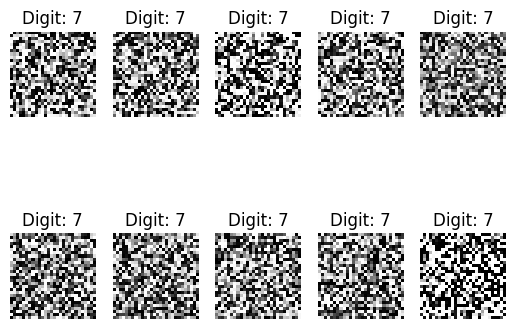

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
train(epochs=10, batch_size=64, save_interval=1000, specific_digit=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


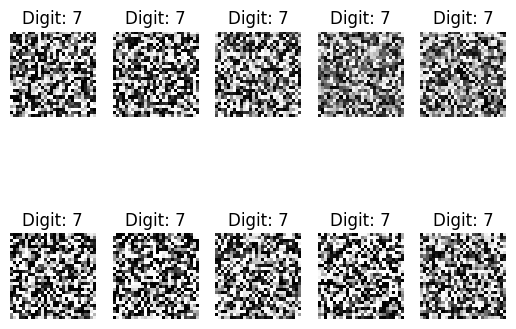

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


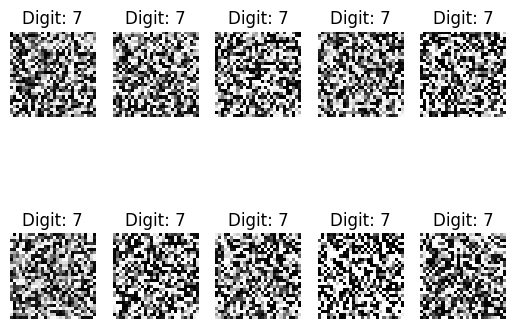

In [11]:
save_images(epoch=100, specific_digit=7)

**Question 02**
## A**dd label smoothing (e.g., replace real labels of 1 with random values between 0.9 and 1) during training. Analyze how label smoothing affects the training process and the quality of generated images**. **bold text**

In [13]:
def train(epochs, batch_size=128, save_interval=200, specific_digit=None, label_smoothing=True):
    # Real labels (smoothed between 0.9 and 1) and fake labels (still 0)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Apply label smoothing: replace real labels with values between 0.9 and 1
        if label_smoothing:
            real = np.random.uniform(0.9, 1.0, size=(batch_size, 1))

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        if specific_digit is not None:
            digit_indices = np.where(Y_train == specific_digit)[0]
            idx = np.random.choice(digit_indices, batch_size)
            real_images, labels = X_train[idx], Y_train[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        # Train the discriminator (real images with smoothed labels, fake images with label 0)
        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (the generator wants the discriminator to output real labels for fake images)
        g_loss = gan.train_on_batch([noise, labels], real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch, specific_digit=specific_digit)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0 [D loss: 1.9118655920028687, acc.: 46.267589926719666%] [G loss: [array(1.915776, dtype=float32), array(1.915776, dtype=float32), array(0.4619945, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


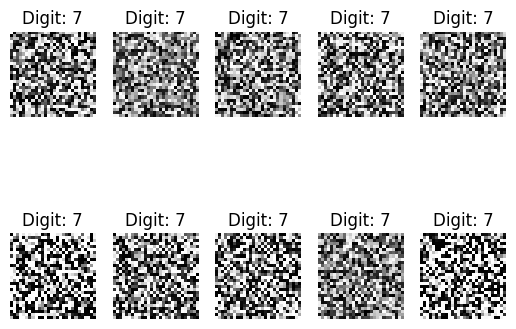

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

In [15]:
# Train CGAN with label smoothing to generate only digit '7'
train(epochs=50, batch_size=64, save_interval=1000, specific_digit=7, label_smoothing=True)


### **Question 03**
# **Generate noise vectors corresponding to two different digits (e.g., '3' and '8'). Perform interpolation between the two noise vectors and visualize how the generated images morph from one digit to the other.**

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Function to perform linear interpolation between two vectors
def interpolate_vectors(vec1, vec2, steps=10):
    alpha_values = np.linspace(0, 1, steps)
    interpolated_vectors = [(1 - alpha) * vec1 + alpha * vec2 for alpha in alpha_values]
    return np.array(interpolated_vectors)

# Function to visualize interpolation between two digits
def visualize_interpolation(generator, digit1, digit2, steps=10):
    # Generate random noise vectors for digit1 and digit2
    noise_vec1 = np.random.normal(0, 1, (1, 100))
    noise_vec2 = np.random.normal(0, 1, (1, 100))

    # Generate labels for digit1 and digit2
    label_vec1 = np.array([digit1])
    label_vec2 = np.array([digit2])

    # Interpolate between the two noise vectors
    interpolated_noise = interpolate_vectors(noise_vec1, noise_vec2, steps)

    # Create labels for interpolation (staying fixed at digit1)
    interpolated_labels = np.ones((steps, 1)) * digit1

    # Generate images for digit1 and digit2 interpolation
    gen_images = generator.predict([interpolated_noise, interpolated_labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale images to [0, 1]

    # Plot the interpolated images
    plt.figure(figsize=(15, 5))
    for i in range(steps):
        plt.subplot(1, steps, i + 1)
        plt.imshow(gen_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

# Visualize the morphing from digit '3' to digit '8'
visualize_interpolation(generator, digit1=3, digit2=8, steps=10)


ValueError: Input 0 of layer "functional_49" is incompatible with the layer: expected shape=(None, 100), found shape=(10, 1, 100)